In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# NN imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Random Forest imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

/kaggle/input/stellar-classification-dataset-sdss17/star_classification.csv


2025-08-07 15:45:15.057872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754581515.293998      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754581515.358423      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
star_data = pd.read_csv("/kaggle/input/stellar-classification-dataset-sdss17/star_classification.csv")
#print(str(star_data))
star_data.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [3]:
star_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

<Axes: xlabel='class'>

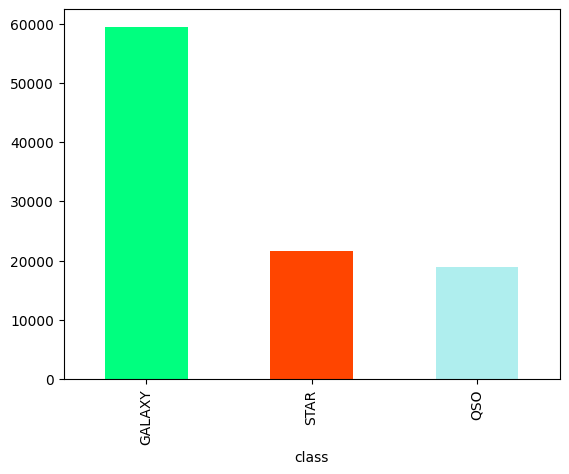

In [4]:
colors = ['springgreen', 'orangered', 'paleturquoise']
class_count = star_data["class"].value_counts()
class_count.plot(color = colors, kind = "bar", x = "class", y = "count")

In [5]:
fig = px.scatter(star_data[:100], x = "r", y = "redshift", color="class")
fig.show()

In [6]:
from sklearn.feature_selection import f_regression

classless_sd = star_data.drop(['class'], axis = 1)
p_value_matrix = []
for i in range(len(classless_sd.columns)):
    f_statistic, p_values = f_regression(classless_sd, classless_sd[str(classless_sd.columns[i])])
    p_value_matrix.append(p_values)
print(p_value_matrix)

[array([1.00000000e+000, 1.40197846e-005, 0.00000000e+000, 1.28770344e-006,
       6.75415147e-007, 0.00000000e+000, 0.00000000e+000, 1.25559076e-005,
       0.00000000e+000, 1.00000000e+000, 5.17425196e-050, 2.21857253e-023,
       0.00000000e+000, 3.23681711e-095, 0.00000000e+000, 0.00000000e+000,
       2.28730745e-100]), array([1.39845089e-05, 1.00000000e+00, 0.00000000e+00, 6.28134294e-01,
       4.43633023e-01, 2.86882112e-12, 8.81131175e-14, 3.56179361e-01,
       1.39850793e-05, 1.00000000e+00, 5.90546980e-10, 0.00000000e+00,
       4.19407269e-01, 5.98062751e-01, 4.19279692e-01, 2.84216037e-10,
       5.65571819e-22]), array([0.00000000e+000, 0.00000000e+000, 1.00000000e+000, 5.12012857e-001,
       2.65201842e-001, 3.06725960e-002, 1.56548035e-001, 2.51057539e-001,
       0.00000000e+000, 1.00000000e+000, 7.00853332e-025, 0.00000000e+000,
       4.18738543e-278, 1.41528035e-023, 4.18861867e-278, 5.78235563e-254,
       4.06961210e-019]), array([1.28371301e-06, 6.28134294e-01,

In [7]:
pv_df = pd.DataFrame(columns = classless_sd.columns)
for i in range(len(p_value_matrix)):
    pv_df.loc[i] = p_value_matrix[i]

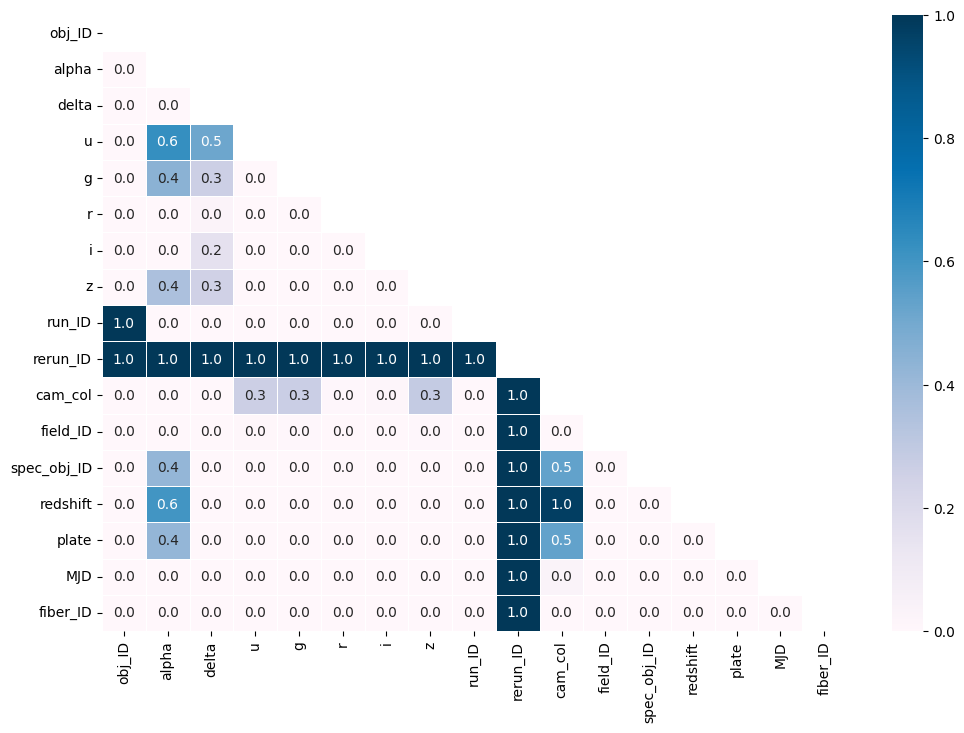

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

mask = np.triu(np.ones_like(pv_df, dtype=bool))
pv_df_named = pv_df.rename(index = dict(zip(range(len(pv_df.index.values)), list(pv_df.columns.values))))
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(pv_df_named, cmap="PuBu", annot = True, linewidths=0.5, fmt= '.01f', mask = mask, ax = ax)
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



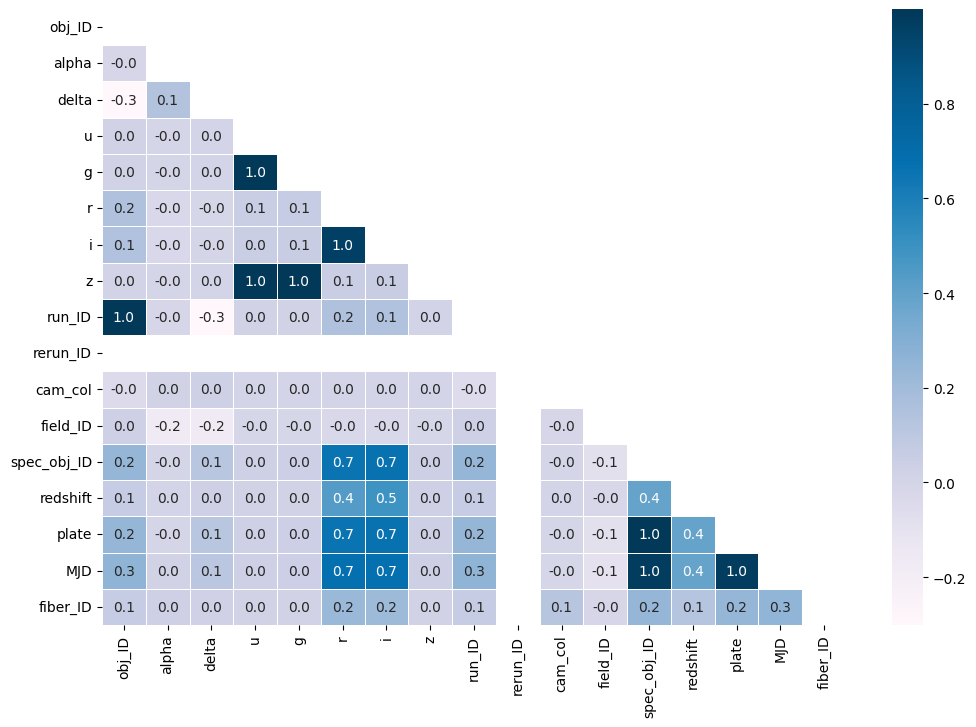

In [9]:
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(classless_sd.corr(), cmap="PuBu", annot = True, linewidths=0.5, fmt= '.01f', mask = mask, ax = ax)
plt.show()

## Preparing data

In [10]:
from sklearn.model_selection import train_test_split
print(star_data.shape[0])
#drop unwanted columns
sd_x = star_data.drop(["obj_ID", "class", "run_ID", "field_ID", "MJD"], axis = 1)
sd_y = star_data[["class"]]
print("Input shape: " + str(sd_x.shape[1]))

#shuffle and sample data
x_train, x_test, y_train, y_test = train_test_split(sd_x, sd_y, test_size = 0.2, random_state = 21)

x_train.head()

100000
Input shape: 13


,alpha,delta,u,g,r,i,z,rerun_ID,cam_col,spec_obj_ID,redshift,plate,fiber_ID
12309,207.658517,-0.115732,24.77283,21.78092,20.23469,19.34936,18.97957,301,3,4.548839e+18,0.503653,4040,739
91699,20.635842,-5.175624,22.37689,21.85837,20.53368,19.76179,19.18856,301,3,7.934335e+18,0.588740,7047,431
90457,223.679778,44.692565,24.07099,23.35097,21.47563,20.42375,19.70248,301,2,9.561416e+18,0.633235,8492,997
78861,10.883924,9.892638,23.57863,22.61047,20.88000,19.49725,18.69369,301,3,6.986320e+18,0.815029,6205,403
29219,195.222111,46.206963,19.07866,18.07061,17.75331,17.72686,17.63795,301,2,3.790909e+18,-0.000632,3367,13


## NN (MLP) Classification solution

In [11]:
# convert to numpy arrays
X_train = x_train.values
X_test = x_test.values

# encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.transpose().squeeze())
y_test_encoded = label_encoder.transform(y_test.transpose().squeeze())
print(label_encoder.classes_)

#convert to one-hot e.g. Galaxy -> [1,0,0]
y_train_hot = to_categorical(y_train_encoded, num_classes=3)
y_test_hot = to_categorical(y_test_encoded, num_classes=3)

['GALAXY' 'QSO' 'STAR']


In [12]:
# initialise TF model:
model = Sequential([
    Dense(64, input_dim=13, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # One output unit per class
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # loss function for one-hot
              metrics=['accuracy'])

# train model

model.fit(X_train, y_train_hot,
          epochs=50,
          batch_size=16,
          validation_data=(X_test, y_test_hot))

#evaluate
loss, accuracy = model.evaluate(X_test, y_test_hot)
print(f"Test Accuracy: {accuracy:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

2025-08-07 15:45:38.187263: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4210 - loss: 15590855838531584.0000 - val_accuracy: 0.5939 - val_loss: 14391594669047808.0000
Epoch 2/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.4192 - loss: 7628145922408448.0000 - val_accuracy: 0.5939 - val_loss: 4301354986110976.0000
Epoch 3/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.4216 - loss: 3808949870526464.0000 - val_accuracy: 0.2155 - val_loss: 1604779230887936.0000
Epoch 4/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.4202 - loss: 1522339481124864.0000 - val_accuracy: 0.5939 - val_loss: 1.1511
Epoch 5/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5946 - loss: 1.0366 - val_accuracy: 0.5939 - val_loss: 0.9563
Epoch 6/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5928 - loss: 0.9573 - val_accuracy: 0.5939 - val_loss: 0.9562
Epoch 7/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5947 - loss: 0.9554 - val_accuracy: 0.

## Random Forest solution

In [13]:
# create and train random forest
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train_encoded)

RandomForestClassifier()

In [14]:
# test random forest
y_prediction = random_forest.predict(x_test)
accuracy = accuracy_score(y_test_encoded, y_prediction)
print(accuracy)

0.97945
